# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [95]:
# Installing the libraries with the specified version.
!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [96]:
# Installing Libraries
# Libraries for Math Operations
import math

# Library for creating data paths
import os

# Library for randomly selecting data points
import random

# Library for performing numerical computations
import numpy as np
import pandas as pd

# Library for creating and showing plots
import matplotlib.pyplot as plt
import seaborn as sns
import cv2                                                                                       # Importing openCV for image processing


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix


# Display images using OpenCV
from google.colab.patches import cv2_imshow

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
# Loading the image file of the dataset
images = np.load('/content/drive/MyDrive/images.npy')

# Loading the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [133]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 RGB images of shape 128 x 128 X 3, each image having 3 channels.

### Ploting Images

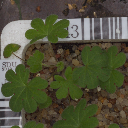

In [134]:
cv2_imshow(images[3])

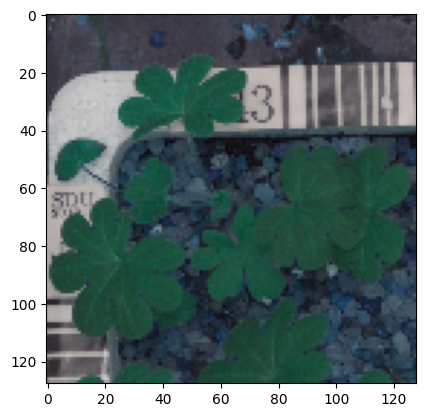

In [135]:
plt.imshow(images[3])

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [136]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

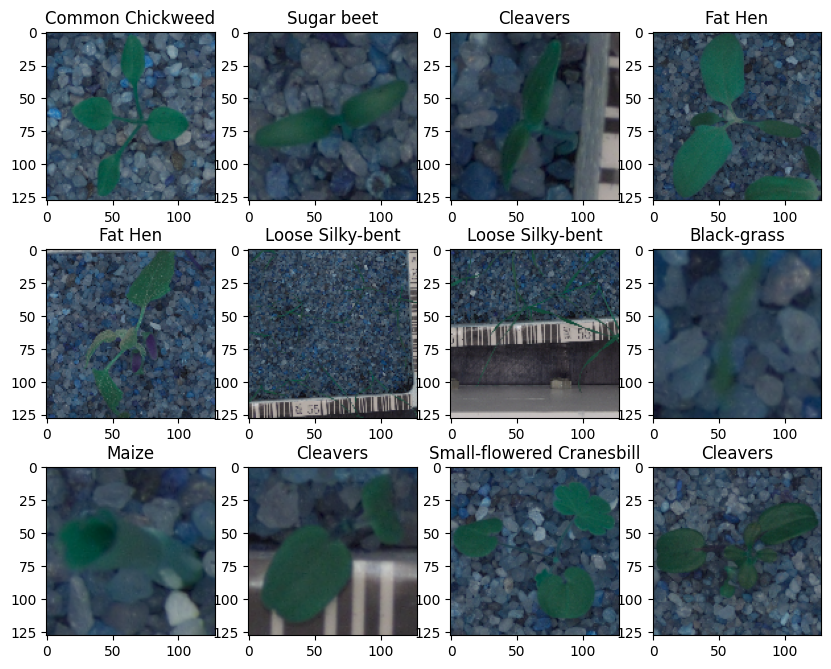

In [137]:
plot_images(images,labels)

Some images are blurry, which others are sharp

### Checking for Data Imbalance

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600'),
  Text(700.0, 0, '700')])

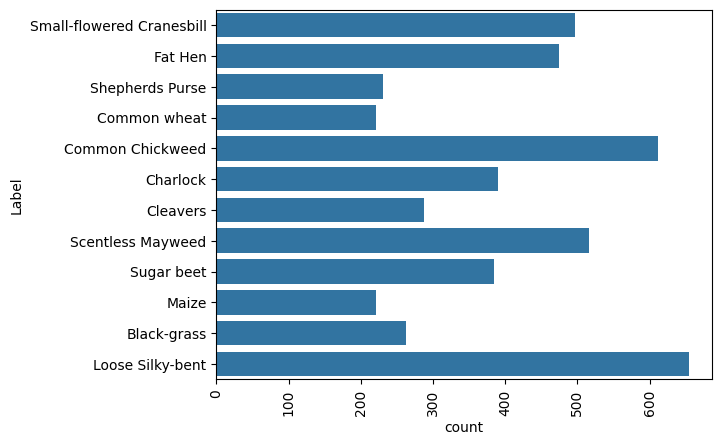

In [138]:
 sns.countplot(labels['Label'])
 plt.xticks(rotation='vertical')

There is data imbalance as images for black-grass, Maize, Shepherds Purse, Common Wheat and others are not enough.

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [139]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [140]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [141]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)


In [142]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Treating Data Imbalance

In [143]:
from sklearn.utils import class_weight

labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
#print calculated class weights
class_weights

{np.int64(0): np.float64(0.7974709784411277),
 np.int64(1): np.float64(0.8348524305555556),
 np.int64(2): np.float64(1.714349376114082),
 np.int64(3): np.float64(1.7909683426443204),
 np.int64(4): np.float64(0.6476430976430977),
 np.int64(5): np.float64(1.0145042194092826),
 np.int64(6): np.float64(1.3818247126436782),
 np.int64(7): np.float64(0.7669457735247209),
 np.int64(8): np.float64(1.0275106837606838),
 np.int64(9): np.float64(1.7909683426443204),
 np.int64(10): np.float64(1.5050860719874803),
 np.int64(11): np.float64(0.604874213836478)}

### Encode the target labels

In [144]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

### Data Normalization

In [145]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [146]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [147]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [148]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         131,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,548 (591.98 KB)

 Trainable params: 151,548 (591.98 KB)

 Non-trainable params: 0 (0.00 B)

### Fitting the Training Data

In [115]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=60,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=128,
            verbose=2,
            class_weight=class_weights
)

Epoch 1/60
31/31 - 10s - 323ms/step - accuracy: 0.1050 - loss: 2.9476 - val_accuracy: 0.1308 - val_loss: 2.4507
Epoch 2/60
31/31 - 3s - 112ms/step - accuracy: 0.1695 - loss: 2.8218 - val_accuracy: 0.2780 - val_loss: 2.3053
Epoch 3/60
31/31 - 1s - 39ms/step - accuracy: 0.2300 - loss: 2.6297 - val_accuracy: 0.3271 - val_loss: 2.1776
Epoch 4/60
31/31 - 1s - 23ms/step - accuracy: 0.2537 - loss: 2.4888 - val_accuracy: 0.3364 - val_loss: 2.0913
Epoch 5/60
31/31 - 1s - 42ms/step - accuracy: 0.2563 - loss: 2.4016 - val_accuracy: 0.3505 - val_loss: 2.0571
Epoch 6/60
31/31 - 1s - 32ms/step - accuracy: 0.2776 - loss: 2.3397 - val_accuracy: 0.3832 - val_loss: 1.9953
Epoch 7/60
31/31 - 1s - 37ms/step - accuracy: 0.2971 - loss: 2.2582 - val_accuracy: 0.3715 - val_loss: 1.9438
Epoch 8/60
31/31 - 1s - 26ms/step - accuracy: 0.3044 - loss: 2.2198 - val_accuracy: 0.3645 - val_loss: 1.9773
Epoch 9/60
31/31 - 1s - 26ms/step - accuracy: 0.3062 - loss: 2.2128 - val_accuracy: 0.3832 - val_loss: 1.8797
Epoch 1

### Model Evaluation

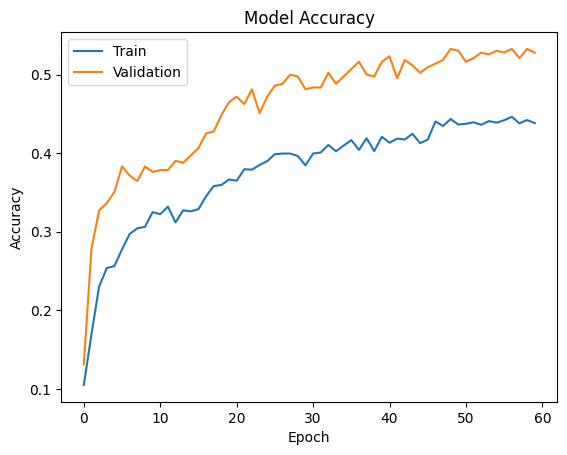

In [116]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Validation is higher than training, which suggenst that that the training is noisier than the validation set

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [117]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [118]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding = 'same'))


model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding = 'same'))


model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding = 'same'))
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt=Adam()

# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,780 (198.36 KB)

 Trainable params: 50,524 (197.36 KB)

 Non-trainable params: 256 (1.00 KB)

In [119]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the learning rate reduction callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by half
    patience=5,          # Wait for 5 epochs before reducing
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print when learning rate is reduced
)

In [120]:
history_2 = model.fit( X_train_normalized, y_train_encoded,
            epochs=60,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=128,
            verbose=2,
            class_weight=class_weights,
                     callbacks=[lr_scheduler])

Epoch 1/60
31/31 - 12s - 371ms/step - accuracy: 0.1874 - loss: 2.7814 - val_accuracy: 0.1379 - val_loss: 2.4693 - learning_rate: 1.0000e-03
Epoch 2/60
31/31 - 3s - 85ms/step - accuracy: 0.3444 - loss: 2.2012 - val_accuracy: 0.1379 - val_loss: 2.5598 - learning_rate: 1.0000e-03
Epoch 3/60
31/31 - 1s - 39ms/step - accuracy: 0.4292 - loss: 1.8455 - val_accuracy: 0.1379 - val_loss: 2.8045 - learning_rate: 1.0000e-03
Epoch 4/60
31/31 - 1s - 40ms/step - accuracy: 0.4903 - loss: 1.5527 - val_accuracy: 0.1379 - val_loss: 3.1251 - learning_rate: 1.0000e-03
Epoch 5/60
31/31 - 1s - 43ms/step - accuracy: 0.5545 - loss: 1.3463 - val_accuracy: 0.1379 - val_loss: 3.6283 - learning_rate: 1.0000e-03
Epoch 6/60

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 - 1s - 41ms/step - accuracy: 0.5997 - loss: 1.2054 - val_accuracy: 0.1379 - val_loss: 3.9822 - learning_rate: 1.0000e-03
Epoch 7/60
31/31 - 1s - 37ms/step - accuracy: 0.6434 - loss: 1.0686 - val_accuracy: 0.1379 - 

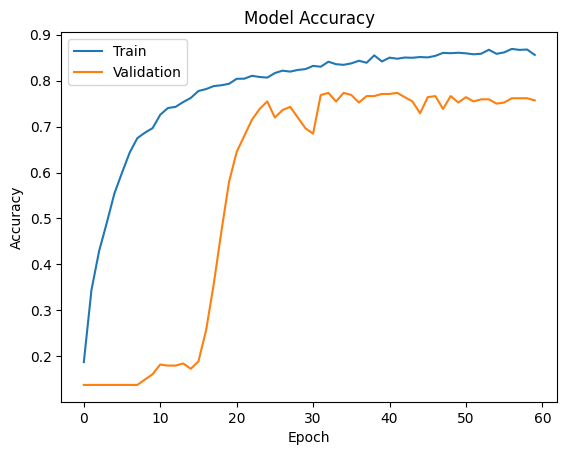

In [121]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Validation is generalizing well.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [122]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [123]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
)

In [124]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding = 'same'))


model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding = 'same'))
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))


# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt=Adam()

# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,780 (198.36 KB)

 Trainable params: 50,524 (197.36 KB)

 Non-trainable params: 256 (1.00 KB)

In [125]:
# Epochs
epochs = 60
# Batch size
batch_size =128

history_3 = model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1, class_weight=class_weights)

Epoch 1/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - accuracy: 0.1446 - loss: 3.1445 - val_accuracy: 0.0537 - val_loss: 2.5036
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2266 - loss: 2.5680 - val_accuracy: 0.0561 - val_loss: 2.5048
Epoch 3/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.2813 - loss: 2.4182 - val_accuracy: 0.0561 - val_loss: 2.5259
Epoch 4/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4062 - loss: 1.9430 - val_accuracy: 0.0561 - val_loss: 2.5262
Epoch 5/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.3751 - loss: 1.9665 - val_accuracy: 0.1402 - val_loss: 2.5627
Epoch 6/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4219 - loss: 1.6788 - val_accuracy: 0.1425 - val_loss: 2.5685
Epoch 7/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.4467 - loss: 1.7002 - val_accuracy: 0.1355 - val_loss: 2.8162
Epoch 8/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5312 - loss: 1.3934 - val_accuracy: 0.1355 - 

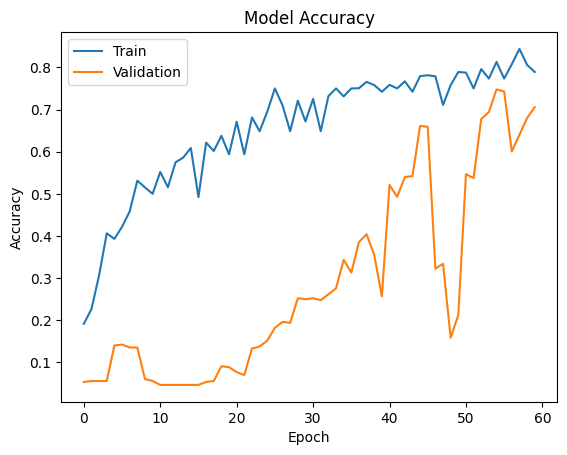

In [126]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Though model is overfitting slightly, this is good performance

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

In [127]:
# Extract accuracy values
history_list = [history_1, history_2, history_3]
model_names = ["Base Model", "Reduce LRonPlateau Model", "Data Augmentation"]

# Create a dictionary to store results
results = {
    "Model": [],
    "Train Accuracy": [],
    "Validation Accuracy": []
}

for i, history in enumerate(history_list):
    train_acc = max(history.history["accuracy"])  # Best training accuracy
    val_acc = max(history.history["val_accuracy"])  # Best validation accuracy

    results["Model"].append(model_names[i])
    results["Train Accuracy"].append(round(train_acc, 4))
    results["Validation Accuracy"].append(round(val_acc, 4))

# Convert to DataFrame and display
df_results = pd.DataFrame(results)
print(df_results)

                      Model  Train Accuracy  Validation Accuracy
0                Base Model          0.4463               0.5327
1  Reduce LRonPlateau Model          0.8690               0.7734
2         Data Augmentation          0.8438               0.7477


From the above table, the model with the best performance is the Data Augmentation Model, though LRON model is also good.

In [128]:
# Fitting Model on Test Data
test_eval = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - 44ms/step - accuracy: 0.7074 - loss: 0.8487


In [129]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


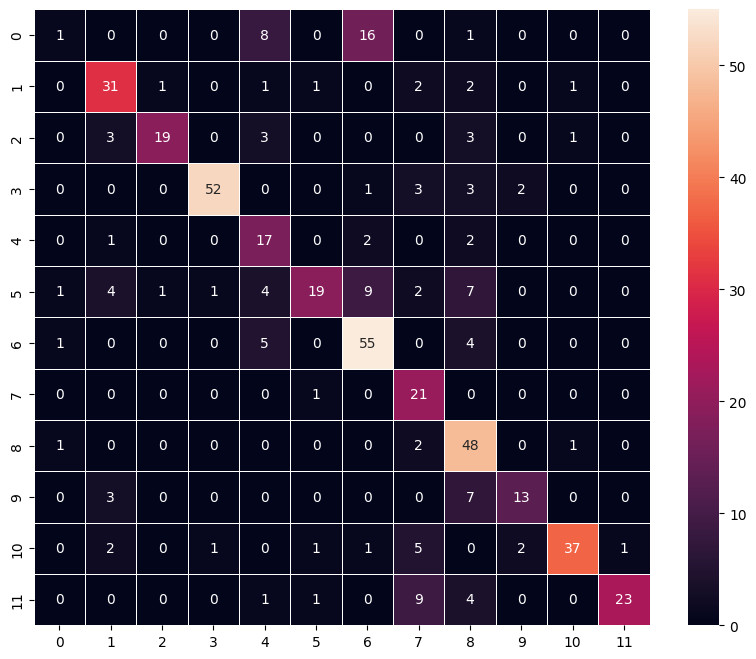

In [130]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

* Majority of the images have been correctly classified.
* Model performs poorly on images on Columns 12, 11, 6, 5 and 0, however in each case, majority of the images were correctly classified.

### Visualizing the prediction

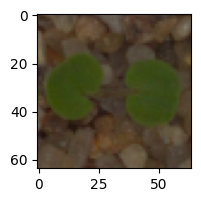

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


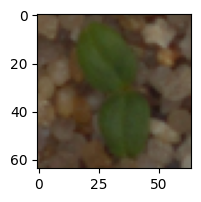

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Label ['Cleavers']
True Label Cleavers


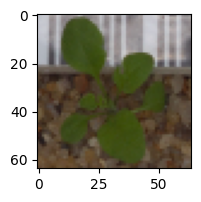

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [131]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

## Actionable Insights and Business Recommendations

* The is the need for furthure improvement of the model.
* The model can potentially be used to develop an AI-powered mobile or web application that allows farmers to scan seedlings and receive real-time identification, growth tracking, and recommendations.
* The industry can deploy the model into drone-based surveillance systems for large-scale farm monitoring.

_____